# Transfer learning

![inline](images/mv2.png)

Because the early later structures that make up a dog are the same as the ones that make up furniture, we can use a network trained to distinguish dogs from cats to classify rooms. To do this we take the former model and retrain the later layers of the neural network to combine shapes into furniture rather than animals. The benefit of this technique, called transfer learning, is that because the network has seen so many images of animals, the work of the earlier layers is done. It just needs to see some examples of furniture to make a furniture classifier. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


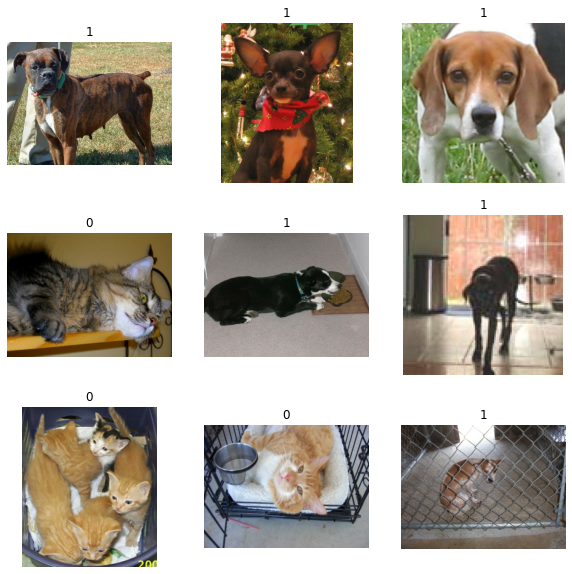

In [2]:
import tensorflow_datasets as tfds

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

"""
These are the first 9 images in the training dataset -- as you can see, they're all
 different sizes.
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


In [3]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


## Transfer learning workflow

(from the Keras Docs)

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

In general, it's a good practice to develop models that take raw data as input, as opposed to models that take already-preprocessed data. The reason being that, if your model expects preprocessed data, any time you export your model to use it elsewhere (in a web browser, in a mobile app), you'll need to reimplement the exact same preprocessing pipeline. This gets very tricky very quickly. So we should do the least possible amount of preprocessing before hitting the model.

## Simple Model

Let us use an existing model and see how it does

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False
) 

In [4]:
def get_features_and_labels(dataset): 
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.Xception.preprocess_input(images) 
        features = base_model.predict(preprocessed_images) 
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_ds) 
val_features, val_labels = get_features_and_labels(validation_ds) 
test_features, test_labels = get_features_and_labels(test_ds)

```python
inputs = keras.Input(shape=(150, 150, 3))
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
```

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(inputs) # or Flatten()
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath="feature_extraction.keras",
                save_best_only=True,
                monitor="val_loss")
       ]

In [ ]:
history = model.fit(
            train_features, train_labels,
            epochs=20,
            validation_data=(val_features, val_labels),
            callbacks=callbacks)

## Data augmentation

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [5]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

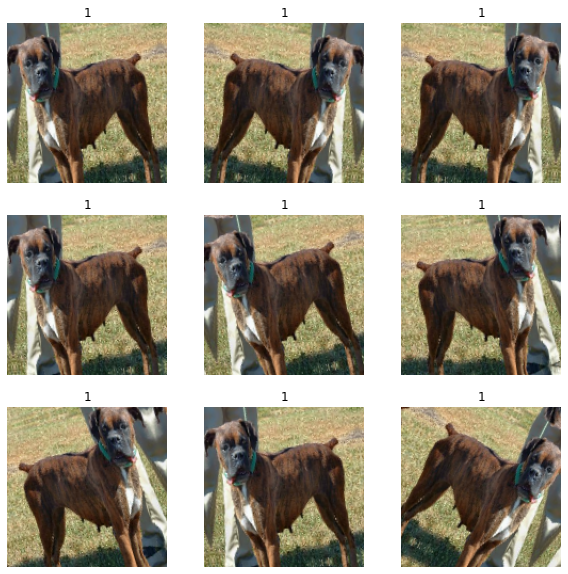

In [6]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False
)  # Do not include the ImageNet classifier at the top.

In [8]:
base_model.trainable = False

In [9]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be normalized
x = keras.applications.xception.preprocess_input(x)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [11]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [13]:
epochs = 20
history = model.fit(train_ds, 
    epochs=epochs, 
    validation_data=validation_ds
    callbacks = callbacks)

Epoch 1/20
291/291 [==============================] - 26s 89ms/step - loss: 0.1106 - binary_accuracy: 0.9550 - val_loss: 0.0766 - val_binary_accuracy: 0.9729
Epoch 2/20
291/291 [==============================] - 26s 89ms/step - loss: 0.1085 - binary_accuracy: 0.9534 - val_loss: 0.0762 - val_binary_accuracy: 0.9708
Epoch 3/20
291/291 [==============================] - 25s 88ms/step - loss: 0.1031 - binary_accuracy: 0.9578 - val_loss: 0.0793 - val_binary_accuracy: 0.9708
Epoch 4/20
291/291 [==============================] - 26s 88ms/step - loss: 0.0930 - binary_accuracy: 0.9615 - val_loss: 0.0709 - val_binary_accuracy: 0.9733
Epoch 5/20
291/291 [==============================] - 26s 89ms/step - loss: 0.0994 - binary_accuracy: 0.9584 - val_loss: 0.0765 - val_binary_accuracy: 0.9721
Epoch 6/20
291/291 [==============================] - 29s 101ms/step - loss: 0.1007 - binary_accuracy: 0.9591 - val_loss: 0.0721 - val_binary_accuracy: 0.9733
Epoch 7/20
291/291 [==============================]

In [ ]:

test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

## Unfreezing more than just the top

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [18]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history2 = model.fit(train_ds, 
    epochs=epochs, 
    validation_data=validation_ds,
    callbacks = callbacks)

In [ ]:
model = keras.models.load_model("fine_tuning.keras") 
test_loss, test_acc = model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

## One shot learning on your iphone

![inline](images/mv3.png)

Apple’s Face Id works by computing the output of the later layers of a neural network after seeing your image. We call this your embedding. When you try and get into your phone later, it re-performs inference on your new photo. If your new embedding is similar to your old one, it lets you in. Image from Valigi and Mauro (2020).

![inline](images/mv4.png)

Imagine you are looking at legal documents, or contracts. The number of contracts you have access to are likely to be smaller than the size of reddit or wikipedia. But by training your initial model on the larger Reddit and wikipedia, and then transferring to your smaller contract data, you can particularize domain specific embeddings from the more general ones. The models trained on the bigger data pick up basic vocabulary and grammar, which are useful for pretty much everything and now you can make them specific to your domain: insurance claims or EMR notes or contracts.
